In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import spateo as st
warnings.filterwarnings('ignore')

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packag

In [2]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyvista import PolyData, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

In [3]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_spateo/mouse_heart/figure6")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_h5ad_path = f"droso_{sample_id}_midgut_morpho/h5ad"
out_image_path = f"droso_{sample_id}_midgut_morpho/image/midgut_curl"
Path(out_h5ad_path).mkdir(parents=True, exist_ok=True)
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [4]:
# Read anndata
key = "morpho_curl"
adata = st.read_h5ad(os.path.join(out_h5ad_path, f"droso_{sample_id}_midgut_v4.h5ad"))
adata = adata[:, ~adata.var.index.str.startswith(f"mt:")]

pc_model = st.tdr.read_model(os.path.join(out_h5ad_path, "midgut_morphometrics_pc_model.vtk"))
trajectory_model = st.tdr.read_model(os.path.join(out_h5ad_path, "midgut_morphometrics_trajectory_model.vtk"))
adata

View of AnnData object with n_obs × n_vars = 2159 × 7595
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'V_x', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion', 'morpho_divergence'
    uns: 'VecFld_morpho', 'pp'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## GLM DEGs

In [5]:
import scanpy as sc
adata.X= adata.layers["X_counts"].copy()
sc.pp.normalize_total(adata, target_sum=2e3)
sc.pp.log1p(adata)

In [6]:
st.tl.glm_degs(
    adata=adata,
    fullModelFormulaStr=f'~cr({key}, df=3)',
    key_added="glm_degs",
    qval_threshold=0.01,
    llf_threshold=-100,
)
import pandas as pd
glm_data = pd.DataFrame(adata.uns["glm_degs"]["glm_result"])
glm_data.to_csv(os.path.join(out_image_path, f"midgut_{key}_glm_degs.csv"), sep="\t")
print(glm_data)

|-----? Gene expression matrix must be normalized by the size factor, please check if the input gene expression matrix is correct.If you don't have the size factor normalized gene expression matrix, please run `dynamo.pp.normalize_cell_expr_by_size_factors(skip_log = True)`.
|-----> [Detecting genes via Generalized Additive Models (GAMs)] in progress: 100.0000%
|-----> [Detecting genes via Generalized Additive Models (GAMs)] finished [111.3755s]
        status family  log-likelihood          pval          qval
ct          ok    NB2     -241.457367  1.426273e-15  1.444339e-13
Ance        ok    NB2    -2564.084473  1.220401e-15  1.324135e-12
CG1273      ok    NB2     -210.730606  1.280874e-14  1.216030e-11
kni         ok    NB2     -117.410210  4.475079e-14  2.124264e-11
Npc2g       ok    NB2     -429.673340  3.994807e-12  3.992179e-10
...        ...    ...             ...           ...           ...
CG9444      ok    NB2     -109.103622  4.363518e-04  9.308642e-03
Ten-m       ok    NB2 

In [7]:
print("mex1" in pd.DataFrame(adata.uns["glm_degs"]["glm_result"]).index)
print("sisA" in pd.DataFrame(adata.uns["glm_degs"]["glm_result"]).index)
print("zip" in pd.DataFrame(adata.uns["glm_degs"]["glm_result"]).index)
print("Ssk" in pd.DataFrame(adata.uns["glm_degs"]["glm_result"]).index)
print("Mef2" in pd.DataFrame(adata.uns["glm_degs"]["glm_result"]).index)

False
False
True
False
False


In [6]:
#glm_data = pd.DataFrame(adata.uns["glm_degs"]["glm_result"])

import pandas as pd
glm_data = pd.read_csv(os.path.join(out_image_path, f"midgut_{key}_glm_degs.csv"), sep="\t", index_col=0)
glm_data= glm_data.loc[glm_data["log-likelihood"] <= -300, :]
glm_data= glm_data.loc[glm_data["log-likelihood"] >= -1500, :]
glm_data= glm_data.loc[glm_data["pval"] <= 1e-4, :]
glm_data.to_csv(os.path.join(out_image_path, f"CNS_{key}_selected_glm_degs.csv"), sep="\t")
glm_data

,status,family,log-likelihood,pval,qval
Npc2g,ok,NB2,-429.67334,3.994807e-12,3.992179e-10
Kaz-m1,ok,NB2,-575.46136,8.674078e-12,8.555795e-10
CG2260,ok,NB2,-342.77832,1.073351e-09,9.704885e-08
nur,ok,NB2,-511.38348,1.425138e-09,1.273403e-07
28SrRNA-Psi:CR45855,ok,NB2,-1351.08090,1.093957e-08,9.441599e-07
Pka-C3,ok,NB2,-404.40073,6.919508e-09,3.091392e-06
ed,ok,NB2,-506.00253,9.873565e-08,8.151058e-06
CG43051,ok,NB2,-425.67460,2.444256e-07,1.973986e-05
CG44286,ok,NB2,-542.25850,4.562482e-07,3.572376e-05
CG15152,ok,NB2,-481.03670,5.229585e-07,4.011990e-05


In [10]:
st.pl.glm_fit(
    adata=adata,
    genes=list(glm_data.index),
    ncols=5,
    feature_x=key,
    feature_y="expression",
    glm_key="glm_degs",
    save_show_or_return="all",
    color_key=key,
    color_key_cmap="RdBu_r",
    save_kwargs=dict(path=os.path.join(out_image_path, f"midgut_{key}_glm_degs_fit"), prefix=None, ext="pdf", dpi=300)
)

Saving figure to droso_E7_8h_midgut_morpho/image/midgut_curl/midgut_morpho_curl_glm_degs_fit.pdf...
Done


In [7]:
selected_increased_genes = ["Npc2g", "CG2260", "CG33099", "lncRNA:CR43334", "scf", "nmo", "Tom", "CG12522", "Snp", "CG34383"]
selected_decreased_genes = ["Kaz-m1", "zip", "Pka-C3", "CG15152", "CG6770", "Trx-2", "peb", "CG14715", "CG8005", "Tep4"]
selected_genes = selected_increased_genes + selected_decreased_genes
glm_data = glm_data.loc[selected_genes, :]
glm_data.to_csv(os.path.join(out_image_path, f"midgut_{key}_selected_glm_degs.csv"), sep="\t")

In [36]:
for gn in selected_increased_genes:# list(glm_data.index):
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    pc_index=pc_model.point_data["obs_index"].tolist()
    exp = adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=pc_model, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="Reds")
    
    st.pl.three_d_plot(
        model=pc_model,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"midgut_{key}_glm_degs_genes_{_gn}.pdf")
    )

In [37]:
for gn in selected_increased_genes:
    interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=gn,
                                                    target_points=np.asarray(pc_model.points), device="0",
                                                    training_iter=100)
    interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=gn,
                                                key_added=gn)
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    st.pl.three_d_plot(
        model=interpolated_gp_pc,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=0.6,
        colormap="Reds",
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"midgut_{key}_glm_degs_interpolated_genes_{_gn}.pdf")
    )

{'obs_keys': [], 'var_keys': ['Npc2g']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.42it/s, loss=1.44]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 87.94it/s, loss=1.13]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 104.65it/s, loss=1.03]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 93.16it/s, loss=0.989]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 104.63it/s, loss=0.911]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.62it/s, loss=0.822]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 83.20it/s, loss=0.88]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 92.02it/s, loss=0.835]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 108.19it/s, loss=0.788]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 63.66it/s, loss=0.78]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.60it/s, loss=0.722]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 96.06it/s, loss=0.666]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 115.94it/s, loss=0.871]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 82.99it/s, loss=0.702]

Minibatch: 100%|█████

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [275.2477s]
{'obs_keys': [], 'var_keys': ['CG2260']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 55.05it/s, loss=1.21]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.36it/s, loss=1.09]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 83.64it/s, loss=1.01]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 79.94it/s, loss=0.958]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 81.76it/s, loss=1.01]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 83.86it/s, loss=0.781]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 61.65it/s, loss=0.821]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 77.86it/s, loss=0.738]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 97.98it/s, loss=0.694]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 100.78it/s, loss=0.729]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 86.31it/s, loss=0.793]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 85.96it/s, loss=0.731]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 62.35it/s, loss=0.623]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.47it/s, loss=0.545]

Minibatch: 100%|███████

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [4.7100s]
{'obs_keys': [], 'var_keys': ['CG33099']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 58.58it/s, loss=1.26]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 68.39it/s, loss=1.19]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.98it/s, loss=0.997]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 71.29it/s, loss=0.995]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.51it/s, loss=0.993]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.79it/s, loss=0.869]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.56it/s, loss=0.906]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 59.36it/s, loss=0.923]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.00it/s, loss=0.925]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.34it/s, loss=0.691]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 54.47it/s, loss=0.783]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 66.86it/s, loss=0.66]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.71it/s, loss=0.702]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 71.80it/s, loss=0.566]

Minibatch: 100%|███████

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [5.4539s]
{'obs_keys': [], 'var_keys': ['lncRNA:CR43334']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 56.00it/s, loss=1.21]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.90it/s, loss=1.24]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 79.04it/s, loss=1.02]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 95.26it/s, loss=0.989]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 71.56it/s, loss=0.891]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.20it/s, loss=0.879]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.00it/s, loss=0.755]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.60it/s, loss=0.887]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 58.74it/s, loss=0.78]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 65.44it/s, loss=0.648]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 79.49it/s, loss=0.613]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 69.01it/s, loss=0.624]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 54.51it/s, loss=0.788]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 56.23it/s, loss=0.694]

Minibatch: 100%|████████

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [4.9547s]
{'obs_keys': [], 'var_keys': ['scf']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 61.50it/s, loss=1.24]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.10it/s, loss=1.14]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 64.26it/s, loss=0.962]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.40it/s, loss=0.973]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.45it/s, loss=0.867]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.67it/s, loss=0.814]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 78.28it/s, loss=0.883]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.78it/s, loss=0.838]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 53.59it/s, loss=0.729]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 67.49it/s, loss=0.659]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.03it/s, loss=0.654]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 59.39it/s, loss=0.76]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.12it/s, loss=0.57]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 78.07it/s, loss=0.662]

Minibatch: 100%|████████

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [5.3059s]
{'obs_keys': [], 'var_keys': ['nmo']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 61.47it/s, loss=1.46]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.59it/s, loss=1.26]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.52it/s, loss=1.2]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 79.56it/s, loss=1.03]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 71.36it/s, loss=1.04]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 64.34it/s, loss=0.984]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.54it/s, loss=0.951]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.89it/s, loss=0.984]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 71.75it/s, loss=0.867]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.50it/s, loss=0.908]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 66.43it/s, loss=0.976]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 69.04it/s, loss=0.94]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 71.31it/s, loss=1.09]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 68.87it/s, loss=0.924]

Minibatch: 100%|██████████| 

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [4.8953s]
{'obs_keys': [], 'var_keys': ['Tom']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 63.75it/s, loss=1.65]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 66.94it/s, loss=1.6]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.05it/s, loss=1.34]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.61it/s, loss=1.18]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 56.05it/s, loss=1.23]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 64.89it/s, loss=1.23]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.01it/s, loss=1.33]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.22it/s, loss=1.27]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.58it/s, loss=1.12]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 77.31it/s, loss=1.02]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.27it/s, loss=1.01]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 80.20it/s, loss=1.21]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.74it/s, loss=1.22]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 61.43it/s, loss=1.28]

Minibatch: 100%|██████████| 3/3 [00

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [5.2058s]
{'obs_keys': [], 'var_keys': ['CG12522']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 62.47it/s, loss=1.24]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 65.25it/s, loss=1.12]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.17it/s, loss=1.07]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.12it/s, loss=1.13]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.47it/s, loss=0.88]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 59.14it/s, loss=0.889]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 77.55it/s, loss=0.781]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.02it/s, loss=0.824]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 51.89it/s, loss=1.1]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 67.18it/s, loss=0.79]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.18it/s, loss=0.664]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 70.05it/s, loss=0.749]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.01it/s, loss=0.822]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 94.41it/s, loss=0.694]

Minibatch: 100%|██████████| 

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [4.8280s]
{'obs_keys': [], 'var_keys': ['Snp']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 64.56it/s, loss=1.2]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 67.16it/s, loss=1.13]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.58it/s, loss=1.06]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.04it/s, loss=0.919]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.65it/s, loss=0.833]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.17it/s, loss=0.814]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 65.30it/s, loss=0.824]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 62.71it/s, loss=0.756]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.07it/s, loss=0.785]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.26it/s, loss=0.647]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.57it/s, loss=0.644]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.74it/s, loss=0.619]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 76.75it/s, loss=0.707]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 73.64it/s, loss=0.713]

Minibatch: 100%|████████

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [5.2266s]
{'obs_keys': [], 'var_keys': ['CG34383']}


Minibatch: 100%|██████████| 3/3 [00:00<00:00, 62.66it/s, loss=1.25]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 70.08it/s, loss=1.14]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 75.92it/s, loss=0.941]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 71.96it/s, loss=0.951]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 55.73it/s, loss=0.833]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 65.43it/s, loss=0.826]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 77.65it/s, loss=0.812]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.66it/s, loss=0.875]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 55.60it/s, loss=0.714]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 65.10it/s, loss=0.708]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.33it/s, loss=0.83]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 72.04it/s, loss=0.752]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 69.74it/s, loss=0.665]

Minibatch: 100%|██████████| 3/3 [00:00<00:00, 74.65it/s, loss=0.595]

Minibatch: 100%|███████

|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [4.8396s]


## GO term

In [14]:
import gseapy as gp
import pandas as pd
gp.get_library_name(organism="Fly")

['Allele_LoF_Phenotypes_from_FlyBase_2017',
 'Allele_Phenotypes_from_FlyBase_2017',
 'Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_zscore',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_zscore',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_zscore',
 'Human_Disease_from_FlyBase_2017',
 

In [15]:
# GO-biologial process
go_folder = os.path.join(out_image_path, f"{key}_GO")
Path(go_folder).mkdir(parents=True, exist_ok=True)

go_bp = gp.enrichr(
        gene_list=selected_increased_genes,
        gene_sets="GO_Biological_Process_2018",
        organism="Fly",
        outdir=go_folder,
        no_plot=True,
        verbose=True
)
go_bp_results = pd.read_csv(os.path.join(go_folder, f"GO_Biological_Process_2018.Fly.enrichr.reports.txt"), sep="\t")
gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50, figsize=(5, 20), color="black",
            ofname=os.path.join(go_folder, f"{key}_GO_Biological_Process_2018_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cmap='Spectral', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{key}_GO_Biological_Process_2018_dotplot.pdf"))

2024-05-13 14:20:57,167 [INFO] Run: GO_Biological_Process_2018 
2024-05-13 14:21:07,318 [INFO] Save enrichment results for GO_Biological_Process_2018 
2024-05-13 14:21:07,319 [INFO] Done.


## Checking genes

In [38]:
adata.obs["domains_midgut"] = adata.obs["backbone_nodes"].map(lambda x: "amg" if int(x) in [9,  8, 11, 10,  7, 12,  6,  5,  4] else "pmg")
adata.obs["domains_midgut"].unique()

array(['pmg', 'amg'], dtype=object)

In [39]:
completed_data = []
for gn in glm_data.index:
    data = adata.uns["glm_degs"]["correlation"][gn]
    data = data[["morpho_curl", "expression"]]
    data = data[data["expression"] != 0]
    data["backbone_nodes"] = adata.obs.loc[data.index, "backbone_nodes"]
    data["domains_midgut"] = adata.obs.loc[data.index, "domains_midgut"]
    data["GNs"] = gn
    
    # data.sort_values(by="morpho_acceleration", ascending=True, axis=0, inplace=True)
    completed_data.append(data)

completed_data = pd.concat(completed_data, axis=0)
completed_data

,morpho_curl,expression,backbone_nodes,domains_midgut,GNs
1139-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08,0.000130,1.983700,47,pmg,Npc2g
1164-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08-E8-10_b_S08,0.000113,2.473978,47,pmg,Npc2g
1019-E8-10_b_S09-E8-10_b_S09-E8-10_b_S09-E8-10_b_S09,0.000166,3.058922,45,pmg,Npc2g
1036-E8-10_b_S09-E8-10_b_S09-E8-10_b_S09-E8-10_b_S09,0.000152,2.112964,45,pmg,Npc2g
592-E8-10_b_S10-E8-10_b_S10-E8-10_b_S10-E8-10_b_S10,0.000019,2.100280,41,pmg,Npc2g
...,...,...,...,...,...
813-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16,0.000229,1.960625,46,pmg,CG34383
817-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16,0.000219,2.352205,46,pmg,CG34383
852-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16,0.000212,3.311700,49,pmg,CG34383
692-E8-10_b_S20-E8-10_b_S20-E8-10_b_S20-E8-10_b_S20,0.000026,2.991349,8,amg,CG34383


In [40]:
amg_completed_data = completed_data.loc[completed_data["domains_midgut"].isin(["amg"]), :]
amg_completed_data = amg_completed_data.loc[amg_completed_data["GNs"].isin(selected_decreased_genes), :]

pmg_completed_data = completed_data.loc[completed_data["domains_midgut"].isin(["pmg"]), :]
pmg_completed_data = pmg_completed_data.loc[pmg_completed_data["GNs"].isin(selected_increased_genes), :]
amg_completed_data, pmg_completed_data

(                                                    morpho_curl  expression  \
 978-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16-E8-10_b...     0.000043    1.320017   
 1066-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16-E8-10_...     0.000017    1.965008   
 1157-E8-10_b_S16-E8-10_b_S16-E8-10_b_S16-E8-10_...     0.000047    2.252411   
 648-E8-10_b_S17-E8-10_b_S17-E8-10_b_S17-E8-10_b...     0.000021    2.241067   
 790-E8-10_b_S17-E8-10_b_S17-E8-10_b_S17-E8-10_b...     0.000049    2.895581   
 ...                                                         ...         ...   
 822-E8-10_b_S22-E8-10_b_S22-E8-10_b_S22-E8-10_b...     0.000030    1.487193   
 841-E8-10_b_S22-E8-10_b_S22-E8-10_b_S22-E8-10_b...     0.000026    2.687754   
 883-E8-10_b_S22-E8-10_b_S22-E8-10_b_S22-E8-10_b...     0.000016    1.290622   
 542-E8-10_b_S23-E8-10_b_S23-E8-10_b_S23-E8-10_b...     0.000063    1.703726   
 608-E8-10_b_S23-E8-10_b_S23-E8-10_b_S23-E8-10_b...     0.000052    2.193677   
 
                                      

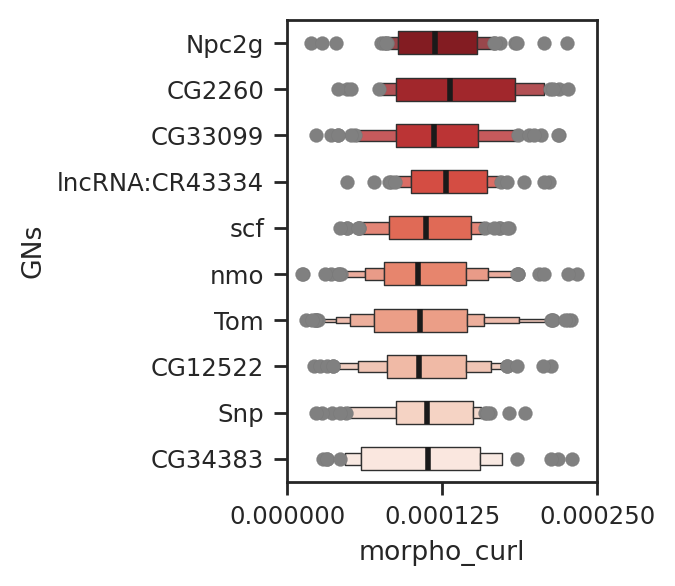

In [41]:
import seaborn as sns

sns.set_theme(context="paper", style="ticks")
f, ax = plt.subplots(figsize=(2, 3))
sns.boxenplot(pmg_completed_data, x="morpho_curl", y="GNs", palette="Reds_r", order=selected_increased_genes,
              linewidth=.5, line_kws=dict(linewidth=2, color="k"), flier_kws=dict(facecolor=".5", linewidth=.1), width=.5)

ax.set_xticks([0, 1.25e-4, 2.5e-4])
plt.savefig(os.path.join(out_image_path, f"{sample_id}_midgut_pmg_morpho_curl_backbone_nodes.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

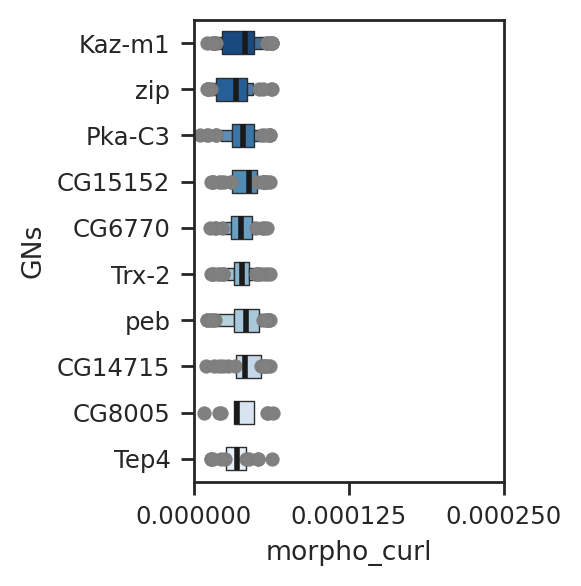

In [42]:
import seaborn as sns

sns.set_theme(context="paper", style="ticks")
f, ax = plt.subplots(figsize=(2, 3))
sns.boxenplot(amg_completed_data, x="morpho_curl", y="GNs", palette="Blues_r", order=selected_decreased_genes,
              linewidth=.5, line_kws=dict(linewidth=2, color="k"), flier_kws=dict(facecolor=".5", linewidth=.1), width=.5)

ax.set_xticks([0, 1.25e-4, 2.5e-4])
plt.savefig(os.path.join(out_image_path, f"{sample_id}_midgut_amg_morpho_curl_backbone_nodes.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()